Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)

Rows with Missing Dates (to be dropped):
Empty DataFrame
Columns: [product_number, department_desc, discount, date_of_order, orders]
Index: []

Dataset shape after dropping rows with missing dates: (1005167, 5)
Remaining missing values:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64

Handling rows with the same date and different prices...
Upper Value Dataset Shape: 

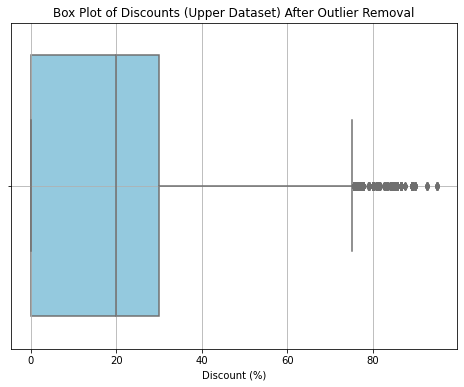

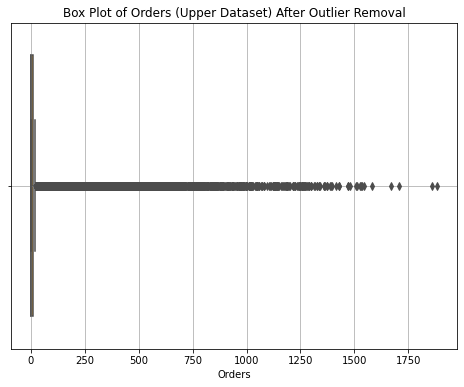

Insight: After removing extreme values, the distribution of 'discount' and 'orders' in both datasets is more representative of the majority of the data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '2022_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove duplicates
data_cleaned.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Handle Missing Dates
# Convert `date_of_order` to datetime and set format explicitly to 'YYYY-MM-DD'
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce').dt.strftime('%Y-%m-%d')

# Identify and print rows with missing dates
missing_date_rows = data_cleaned[data_cleaned['date_of_order'].isnull()]
print("\nRows with Missing Dates (to be dropped):")
print(missing_date_rows)

# Drop rows with missing `date_of_order`
data_cleaned.dropna(subset=['date_of_order'], inplace=True)
print(f"\nDataset shape after dropping rows with missing dates: {data_cleaned.shape}")

# 3. Handle Missing Values
data_cleaned.dropna(subset=['department_desc', 'discount', 'orders'], inplace=True)
print(f"Remaining missing values:\n{data_cleaned.isnull().sum()}")

# 4. Handle Rows with Same Date and Different Prices
print("\nHandling rows with the same date and different prices...")
grouped_data = data_cleaned.groupby(['product_number', 'date_of_order'])
upper_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmax()]).reset_index(drop=True)
lower_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmin()]).reset_index(drop=True)

print(f"Upper Value Dataset Shape: {upper_value_data.shape}")
print(f"Lower Value Dataset Shape: {lower_value_data.shape}")

# Save both datasets
upper_value_data.to_csv('cleaned_orders_discount_data_upper.csv', index=False)
lower_value_data.to_csv('cleaned_orders_discount_data_lower.csv', index=False)
print("Datasets saved as 'cleaned_orders_discount_data_upper.csv' and 'cleaned_orders_discount_data_lower.csv'.")

# 5. Custom Outlier Removal using Percentiles
def remove_outliers_custom(df, column, lower_percentile, upper_percentile):
    """
    Removes outliers based on percentile thresholds.
    Arguments:
    df : pandas.DataFrame - Input dataframe.
    column : str - Column name for which outliers need to be removed.
    lower_percentile : int - Lower percentile for threshold (default=1).
    upper_percentile : int - Upper percentile for threshold (default=99).
    Returns:
    pandas.DataFrame - DataFrame with outliers removed.
    """
    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from both datasets
print("\nRemoving outliers from both datasets...")
original_shape_upper = upper_value_data.shape
original_shape_lower = lower_value_data.shape
upper_value_data = remove_outliers_custom(upper_value_data, 'discount', lower_percentile=1, upper_percentile=99)
upper_value_data = remove_outliers_custom(upper_value_data, 'orders', lower_percentile=1, upper_percentile=99)
lower_value_data = remove_outliers_custom(lower_value_data, 'discount', lower_percentile=1, upper_percentile=99)
# lower_value_data = remove_outliers_custom(lower_value_data, 'orders', lower_percentile=1, upper_percentile=99)

print(f"Upper dataset shape before: {original_shape_upper}, after: {upper_value_data.shape}")
print(f"Lower dataset shape before: {original_shape_lower}, after: {lower_value_data.shape}")

# Save cleaned datasets again after outlier removal
upper_value_data.to_csv('cleaned_orders_discount_data_upper.csv', index=False)
lower_value_data.to_csv('cleaned_orders_discount_data_lower.csv', index=False)
print("Outlier-removed datasets saved as 'cleaned_orders_discount_data_upper.csv' and 'cleaned_orders_discount_data_lower.csv'.")

# Box Plots after Outlier Removal
# Box plot for discounts in the upper dataset after outlier removal
plt.figure(figsize=(8, 6))
sns.boxplot(x=upper_value_data['discount'], color='skyblue')
plt.title('Box Plot of Discounts (Upper Dataset) After Outlier Removal')
plt.xlabel('Discount (%)')
plt.grid(True)
plt.show()

# Box plot for orders in the upper dataset after outlier removal
plt.figure(figsize=(8, 6))
sns.boxplot(x=upper_value_data['orders'], color='orange')
plt.title('Box Plot of Orders (Upper Dataset) After Outlier Removal')
plt.xlabel('Orders')
plt.grid(True)
plt.show()

print("Insight: After removing extreme values, the distribution of 'discount' and 'orders' in both datasets is more representative of the majority of the data.")



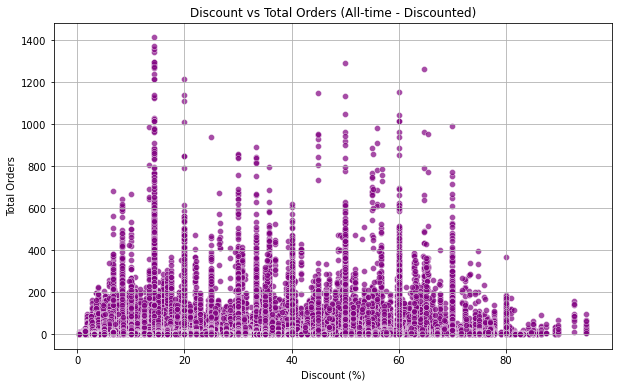

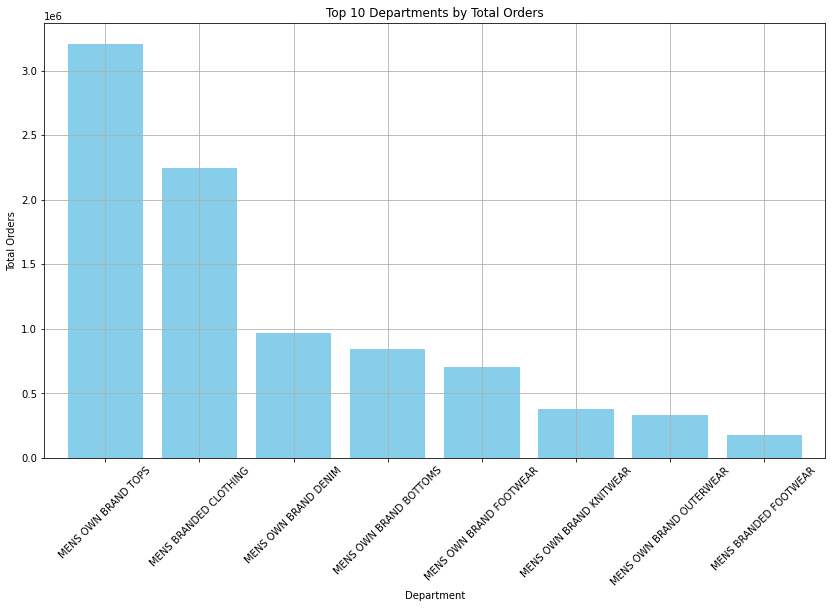

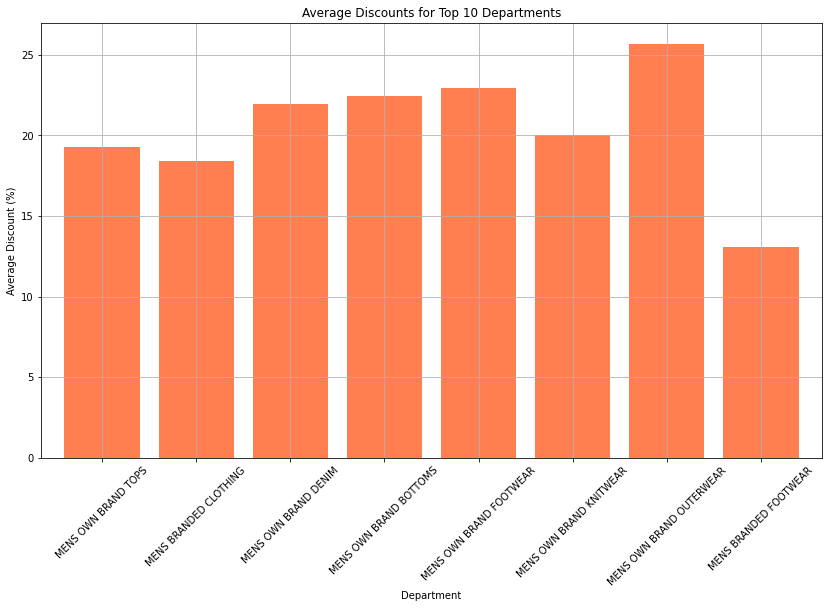

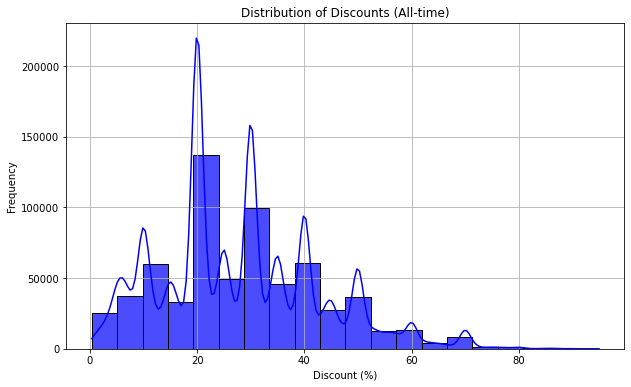

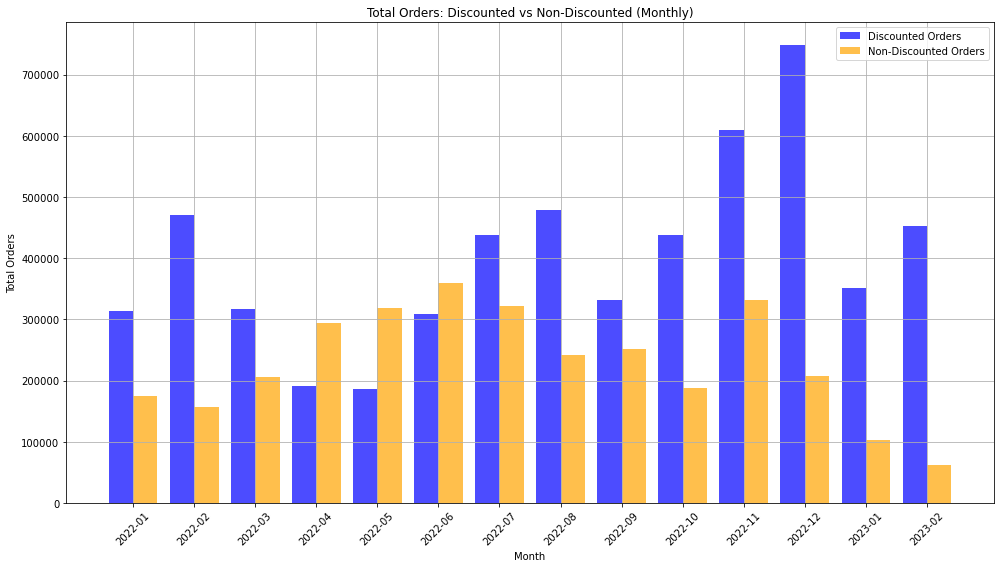

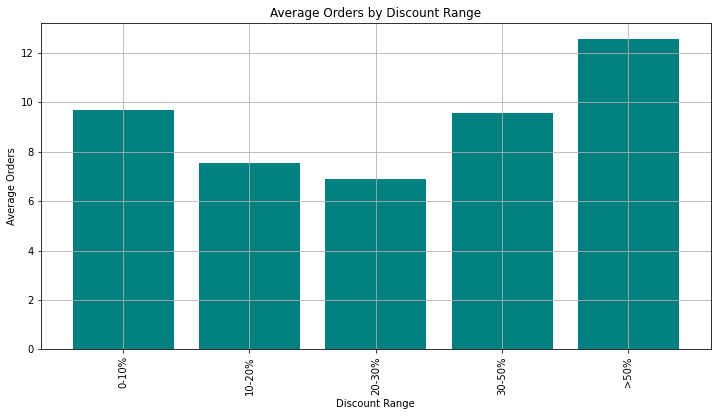

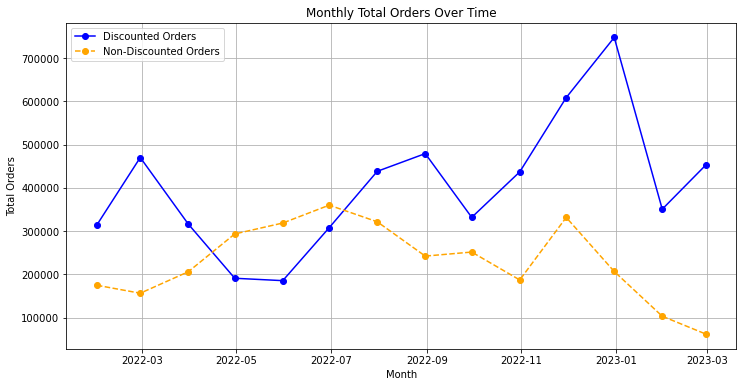

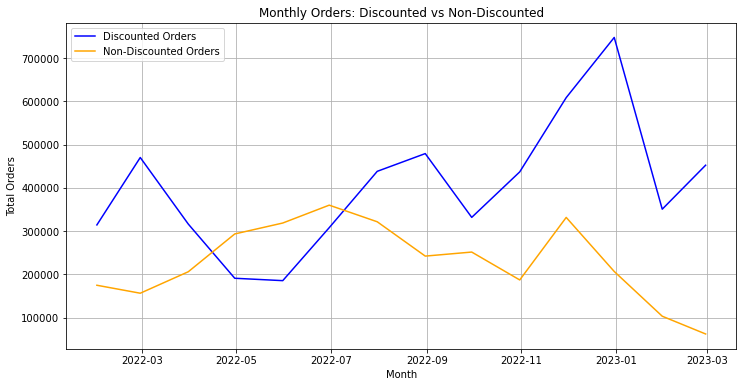

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
file_path = 'cleaned_orders_discount_data_upper.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate discount segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted and non-discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]
non_discounted_data = data_cleaned[data_cleaned['discount'] == 0]

# Aggregate data monthly for discounted and non-discounted separately
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

non_discounted_monthly = non_discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum'
}).reset_index()

# Merge the two datasets for analysis
monthly_data = pd.merge(
    discounted_monthly,
    non_discounted_monthly,
    on='date_of_order',
    how='outer',
    suffixes=('_discounted', '_non_discounted')
)

# Replace NaN with 0 to handle months without any orders for a specific category
monthly_data.fillna(0, inplace=True)

# Add discount range for analysis (for discounted data only)
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
if 'discount_discounted' in monthly_data.columns:
    monthly_data['discount_range'] = pd.cut(monthly_data['discount_discounted'], bins=bins, labels=labels)

### 1. Discount vs Orders Scatter Plot (All-time Aggregation)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discounted_data, alpha=0.7, color="purple")
plt.title('Discount vs Total Orders (All-time - Discounted)')
plt.xlabel('Discount (%)')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

### 2. Top Departments by Total Orders
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

plt.figure(figsize=(14, 8))  # Wider chart
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue', width=0.8)
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3. Average Discounts for Top 10 Departments
plt.figure(figsize=(14, 8))  # Wider chart
dept_aggregated['discount'].head(10).plot(kind='bar', color='coral', width=0.8)
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 4. Distribution of Discounts
plt.figure(figsize=(10, 6))
sns.histplot(discounted_data['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts (All-time)')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 5. Discounted vs Non-Discounted Sales (Monthly)
# Adjust x-axis positions to prevent overlap
x_positions = np.arange(len(monthly_data['date_of_order']))

plt.figure(figsize=(14, 8))  # Wider chart for better readability
plt.bar(
    x_positions - 0.2,  # Offset for Discounted Orders
    monthly_data['orders_discounted'],
    width=0.4,
    label='Discounted Orders',
    color='blue',
    alpha=0.7
)
plt.bar(
    x_positions + 0.2,  # Offset for Non-Discounted Orders
    monthly_data['orders_non_discounted'],
    width=0.4,
    label='Non-Discounted Orders',
    color='orange',
    alpha=0.7
)

# Set x-axis labels
plt.xticks(x_positions, monthly_data['date_of_order'].dt.strftime('%Y-%m'), rotation=45)
plt.title('Total Orders: Discounted vs Non-Discounted (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label overlap
plt.show()

### 6. Average Orders by Discount Range
avg_orders_by_discount = discounted_data.groupby(pd.cut(discounted_data['discount'], bins=bins, labels=labels))['orders'].mean()

plt.figure(figsize=(12, 6))
avg_orders_by_discount.plot(kind='bar', color='teal', width=0.8)
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

### 7. Monthly Total Orders Over Time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date_of_order'], monthly_data['orders_discounted'], marker='o', color='blue', label='Discounted Orders')
plt.plot(monthly_data['date_of_order'], monthly_data['orders_non_discounted'], marker='o', linestyle='--', color='orange', label='Non-Discounted Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

### 8. Monthly Orders: Discounted vs Non-Discounted
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_of_order', y='orders_discounted', data=monthly_data, label='Discounted Orders', color='blue')
sns.lineplot(x='date_of_order', y='orders_non_discounted', data=monthly_data, label='Non-Discounted Orders', color='orange')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()




Average Price Elasticity of Demand (Discounted Orders): 5.233

Extreme Elasticity Months for Discounted Orders:
   date_of_order  elasticity   discount  orders
1     2022-02-28   12.328443  27.348344  470292
2     2022-03-31   81.507224  27.238615  316492
3     2022-04-30   -5.670393  29.140182  191206
4     2022-05-31  -16.514053  29.191096  185689
5     2022-06-30  -11.675574  27.542303  308145
8     2022-09-30   19.630225  28.500434  331937
9     2022-10-31    5.360028  30.184887  437092
11    2022-12-31  -17.496188  27.158004  747749
12    2023-01-31   15.649060  26.236854  350853
13    2023-02-28  -12.530038  25.630420  452466


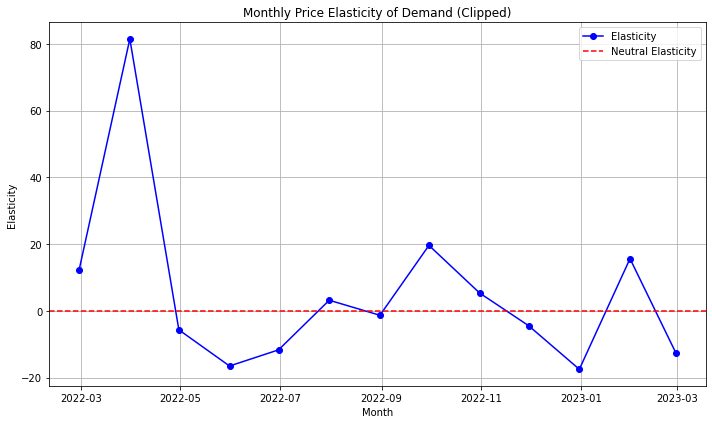

T-Test for Is_summer (Discounted Orders): t-stat = 0.757, p-value = 0.464
T-Test for Is_winter (Discounted Orders): t-stat = -1.210, p-value = 0.250


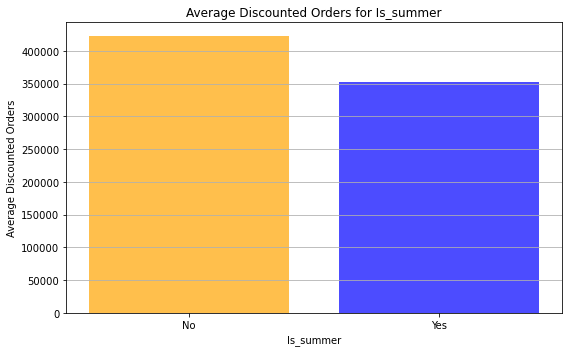

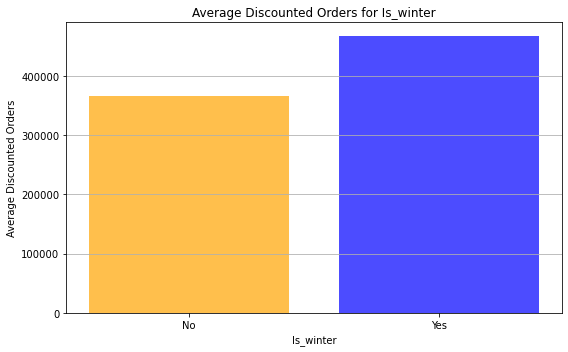


Correlation Analysis:
Overall Pearson Correlation (Discount vs Orders): -0.152

MENS BRANDED CLOTHING Pearson Correlation (Discount vs Orders): 0.070

MENS OWN BRAND TOPS Pearson Correlation (Discount vs Orders): -0.079

MENS OWN BRAND FOOTWEAR Pearson Correlation (Discount vs Orders): -0.156

MENS BRANDED FOOTWEAR Pearson Correlation (Discount vs Orders): 0.004

MENS OWN BRAND BOTTOMS Pearson Correlation (Discount vs Orders): -0.042


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, spearmanr

# Load cleaned data
file_path = 'cleaned_orders_discount_data_upper.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate the discount column segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]

# Aggregate data monthly for discounted data
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

# Drop rows with NaN values
discounted_monthly.dropna(inplace=True)

# Step 3: Corrected Elasticity Calculation
discounted_monthly['pct_change_discount'] = discounted_monthly['discount'].pct_change()
discounted_monthly['pct_change_orders'] = discounted_monthly['orders'].pct_change()

# Avoid division by zero
discounted_monthly['elasticity'] = np.where(
    discounted_monthly['pct_change_discount'] != 0,
    discounted_monthly['pct_change_orders'] / discounted_monthly['pct_change_discount'],
    np.nan
)

# Replace NaN and extreme values if necessary
discounted_monthly['elasticity'] = discounted_monthly['elasticity'].replace([np.inf, -np.inf], np.nan)

# Summary Statistics for Elasticity
avg_elasticity = discounted_monthly['elasticity'].mean()
print(f"\nAverage Price Elasticity of Demand (Discounted Orders): {avg_elasticity:.3f}")

# Investigate Extreme Elasticity Values
extreme_elasticity_months = discounted_monthly.loc[discounted_monthly['elasticity'].abs() > 5]
print("\nExtreme Elasticity Months for Discounted Orders:")
print(extreme_elasticity_months[['date_of_order', 'elasticity', 'discount', 'orders']])

# Elasticity Trend Plot
plt.figure(figsize=(10, 6))
plt.plot(discounted_monthly['date_of_order'], discounted_monthly['elasticity'], label='Elasticity', color='blue', marker='o')
plt.axhline(0, color='red', linestyle='--', label='Neutral Elasticity')
plt.title('Monthly Price Elasticity of Demand (Clipped)')
plt.xlabel('Month')
plt.ylabel('Elasticity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Define Seasonal Features

summer_months = [5,6, 7,8]
winter_months = [12, 1, 2]

discounted_monthly['is_summer'] = discounted_monthly['date_of_order'].dt.month.isin(summer_months).astype(int)
discounted_monthly['is_winter'] = discounted_monthly['date_of_order'].dt.month.isin(winter_months).astype(int)

# Statistical Tests: T-tests for Seasonal Features
seasonal_features = ['is_summer', 'is_winter']

for feature in seasonal_features:
    group1 = discounted_monthly[discounted_monthly[feature] == 0]['orders']
    group2 = discounted_monthly[discounted_monthly[feature] == 1]['orders']
    
    if len(group1) > 1 and len(group2) > 1:  # Ensure enough data for t-tests
        t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
        print(f"T-Test for {feature.capitalize()} (Discounted Orders): t-stat = {t_stat:.3f}, p-value = {p_value:.3f}")
    else:
        print(f"Insufficient data for T-Test on {feature.capitalize()}.")

# Seasonal Graphs for Discounted Orders Only (Plot Both Categories)
for feature in seasonal_features:
    grouped_data = discounted_monthly.groupby(feature)['orders'].mean().reset_index()
    grouped_data[feature] = grouped_data[feature].replace({0: 'No', 1: 'Yes'})
    
    # Plotting bar graph for both "Yes" and "No"
    plt.figure(figsize=(8, 5))
    plt.bar(grouped_data[feature], grouped_data['orders'], color=['orange', 'blue'], alpha=0.7)
    plt.title(f'Average Discounted Orders for {feature.capitalize()}')
    plt.ylabel('Average Discounted Orders')
    plt.xlabel(f'{feature.capitalize()}')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Step 5: Correlation Analysis
print("\nCorrelation Analysis:")

# Overall Correlation (Discount vs Orders)
overall_pearson_corr, _ = pearsonr(discounted_monthly['discount'], discounted_monthly['orders'])
print(f"Overall Pearson Correlation (Discount vs Orders): {overall_pearson_corr:.3f}")

# Department-Specific Correlation
top_departments = data_cleaned['department_desc'].value_counts().index[:5]  # Top 5 departments
for department in top_departments:
    dept_data = data_cleaned[data_cleaned['department_desc'] == department]
    if not dept_data.empty:
        dept_pearson_corr, _ = pearsonr(dept_data['discount'], dept_data['orders'])
        print(f"\n{department} Pearson Correlation (Discount vs Orders): {dept_pearson_corr:.3f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import platform

# Display system details
print(platform.platform())
print(platform.processor())

# Load dataset
data = pd.read_csv('cleaned_orders_discount_data.csv')

# Updated Departments: Adding more relevant departments
selected_departments = [
    'MENS OWN BRAND FOOTWEAR', 'MENS OWN BRAND OUTERWEAR', 'MENS BRANDED FOOTWEAR',
    'MENS OWN BRAND TOPS', 'MENS BRANDED CLOTHING'
]
data = data[data['department_desc'].isin(selected_departments)]

# Handle duplicate discounts by averaging
data = data.groupby(['product_number', 'date_of_order']).agg({
    'discount': 'mean',
    'orders': 'mean',
    'department_desc': 'first'  # Retain the first department for duplicates
}).reset_index()

# Enhanced Feature Engineering
def preprocess_data(data):
    data['date_of_order'] = pd.to_datetime(data['date_of_order'], errors='coerce')
    data['day_of_week'] = data['date_of_order'].dt.dayofweek  # 0=Monday, 6=Sunday
    data['month'] = data['date_of_order'].dt.month
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)  # 1 if Saturday/Sunday
    data['quarter'] = data['date_of_order'].dt.quarter
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)  # June, July, August
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)  # December, January, February
    
    
    data.drop(columns=['date_of_order'], inplace=True, errors='ignore')
    data = pd.get_dummies(data, columns=['department_desc'], drop_first=True)
    return data

data = preprocess_data(data)

# Define Features and Target
def train_model(data, dataset_name):
    X = data.drop(columns=['orders'])
    y = data['orders']

    # Ensure no missing values
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(alpha=0.01),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(),
    }

    results = []
    best_model = None
    best_r2 = float('-inf')
    decision_tree_model = None  # Save Decision Tree model for visualization

    for model_name, model in models.items():
        print(f"\nTraining {model_name} on {dataset_name} dataset...")
        if model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
            param_grids = {
                'Decision Tree': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 10, 20]},
                'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
                'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
            }
            search = RandomizedSearchCV(
                model, param_distributions=param_grids[model_name], n_iter=5, cv=2, random_state=42, n_jobs=-1
            )
            search.fit(X_train, y_train)
            model = search.best_estimator_
            print(f"Best Params for {model_name}: {search.best_params_}")
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        print(f"{model_name} Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

        results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R^2': r2})

        if model_name == 'Decision Tree':
            decision_tree_model = model
        if r2 > best_r2:
            best_r2 = r2
            best_model = model

    # Visualize Decision Tree
    if decision_tree_model:
        plt.figure(figsize=(10, 6))
        plot_tree(decision_tree_model, feature_names=list(X.columns), filled=True, max_depth=3, fontsize=8)
        plt.title(f"Decision Tree Diagram ({dataset_name} Dataset, Depth=3)")
        plt.tight_layout()
        plt.savefig(f"decision_tree_diagram_{dataset_name}.png")
        plt.show()

    # Save metrics to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'model_evaluation_metrics_{dataset_name}.csv', index=False)

    # Save predictions to CSV
    test_data = data.iloc[y_test.index].copy()
    test_data['Predictions'] = np.round(best_model.predict(X_test))
    test_data.to_csv(f'predicted_orders_{dataset_name}.csv', index=False)
    print(f"\nModel evaluation metrics saved for {dataset_name} dataset.")

# Train model on processed data
train_model(data, "Expanded_Departments")
plt.show()


macOS-14.6.1-arm64-arm-64bit
arm

Training Linear Regression on Expanded_Departments dataset...
Linear Regression Results:
MAE: 7.6675, RMSE: 13.3207, R2: 0.0580

Training Lasso Regression on Expanded_Departments dataset...
Lasso Regression Results:
MAE: 7.6672, RMSE: 13.3212, R2: 0.0579

Training Decision Tree on Expanded_Departments dataset...
Best Params for Decision Tree: {'min_samples_split': 10, 'max_depth': None}
Decision Tree Results:
MAE: 4.4627, RMSE: 8.9375, R2: 0.5760

Training Random Forest on Expanded_Departments dataset...
Best Params for Random Forest: {'n_estimators': 200, 'max_depth': None}
Random Forest Results:
MAE: 4.4885, RMSE: 8.8970, R2: 0.5798

Training Gradient Boosting on Expanded_Departments dataset...
